# MNIST generator by RBM

- Provided sample notebook to train single character generator on Colab, I checked what affects the generation quality.
- Comparison of 2 different models by changing CD steps
 - $k=1$ for training
 - $k=200$ for training
- Generation quality is also affected by
 - CD step $k$ for sampling
 - Initial state for sampling

In [13]:
from RBM_helper import  RBM
import torch
import matplotlib.pyplot as plt

rbm_1 = RBM.from_weights('../params/MNIST_k_1_e_500')
rbm_2 = RBM.from_weights('../params/MNIST_k_200_e_500')

## Comparing different models with same initial input and CD steps
- We see that from same random initial input, the model trained larger CD-k step produces better quality image.

Text(0.5, 0, 'k=200, e=1000')

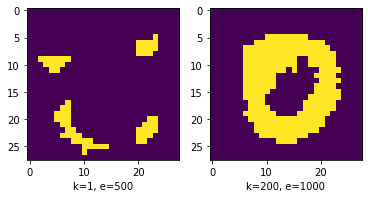

In [20]:
n_vis = rbm_1.n_vis
initial_state = torch.rand(n_vis)
k = 500
image_1 = rbm_1.draw_samples(k, initial_state.clone()).cpu().detach().numpy().reshape(28, 28)
image_2 = rbm_2.draw_samples(k, initial_state.clone()).cpu().detach().numpy().reshape(28, 28)


f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_1)
axarr[0].set_xlabel('k=1, e=500')
axarr[1].imshow(image_2)
axarr[1].set_xlabel('k=200, e=1000')

## PCD-k to sample from low quality model
- Persistent contrastive divergence: using training data as initial state, we can draw high quality sample from less trained model.
- In this case, the image quality for both models do not differ much.

Save complete.


Text(0.5, 0, 'k=200, e=1000')

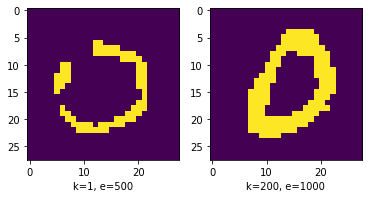

In [31]:

import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    # download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

load()
init()
data = load()
labels = data[1]
data = data[0]
data = data/255 # normalize grey scale values between 0 and 255 to values between 0 and 1
data = np.where(data > 0.5, 1, 0)
data = data[labels == 0]

training_initial_state = torch.Tensor(data[0])
image_3 = rbm_1.draw_samples(k, training_initial_state).cpu().detach().numpy().reshape(28, 28)
image_4 = rbm_2.draw_samples(k, training_initial_state).cpu().detach().numpy().reshape(28, 28)
f, axarr = plt.subplots(1,2)

axarr[0].imshow(image_3)
axarr[0].set_xlabel('k=1, e=500')
axarr[1].imshow(image_4)
axarr[1].set_xlabel('k=200, e=1000')

## Likelihood convergence comparison between different CD steps
- To see how CD step difference affects training, I compare learning curve of different $k$'s
- It clearly shows CD step causes a bottle neck of the training.

Text(0, 0.5, 'Log likelihood')

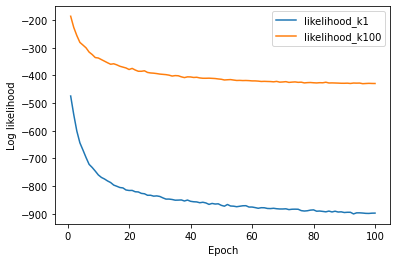

In [54]:
import pandas as pd

df_k1 = pd.read_csv('../training_logs/mnist_k_1_ll.csv', names=['likelihood_k1'], skiprows=1)
df_k100 = pd.read_csv('../training_logs/mnist_k100_ll.csv', names=['likelihood_k100'], skiprows=1)

df_k1.index = list(range(1, 501))
df_k100.index = list(range(1, 101))
df_k1.index.name = 'Epoch'
df_k100.index.name = 'Epoch'

combined_df = pd.concat([df_k1.iloc[:100], df_k100], axis=1)
ax = combined_df.plot()
ax.set_ylabel('Log likelihood')